<h1 align=center><font size = 5>CapStone Project - Compare Neighbourhoods of NewYork and Toronto</font></h1>

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction<a name="introduction"></a>

In this Project we will compare the Neighbourhoods of New York and Toronto. Both being the most populous cities respectively in the United States and Canada, both are surrounded by numerous attractive venues such as restaurants(Italian, Sushi, Mexican, Spanish, Japanese, etc..), Studios(Dance, cycle,Yoga), Park, Bars,Coffee/Cafe shops,Night clubs, Gym, Monuments, Spa, etc..We will compare the nearby venues of both cities and see if they are similar or which has more attractive places around.

## Data <a name="data"></a>

For the analysis of New York and Toronto neighbourhoods and the surrounding attractive places, we need below information:

* List of neighbourhoods of New York and Toronto
* Attractive places in both neighbourhoods

Following process will be followed to collect the data:

* List of neighbourhoods of NY and Toronto are readily available along with the postal codes from different websites. We can get the list and pre-process the data in required format to analyze it.
* Attractive venues in the neighbourhoods can be obtained from FourSquare API.
* Google Maps API Geocoding/reverse can be used to get the location name or latitudes and longitudes.


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

Downloading NY data  https://geo.nyu.edu/catalog/nyu_2451_34572

We will create a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Store all the relavant details in the features key in new variable

In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe.

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


#### Create a map of New York with neighborhoods superimposed on top using folium

In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Let's simplify the above map and segment and cluster only the neighborhoods in Manhattan

In [14]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [15]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [16]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## Methodology <a name="methodology"></a>

First we will collect all the neighbourhoods of NY and Toronto City. 
Next, pre-processing of data will be carried on to get the final data in required format
Next step would be collecting the neighbourhood venues using FourSquare API.
Then do segmentation and clustering of neighbourhoods based on certain criteria and display on the maps for better understanding.

## Analysis <a name="analysis"></a>

Let's do some analysis with the neighbourhood data and get the venues and compare them

#### Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'HB4HSFTYMS1GB54USKYJT0JSQ10A4GMIWLCSES0D5KR0BQ5J' # your Foursquare ID
CLIENT_SECRET = 'TLHE00WA0TOPNSNEOG2JYGW3RV5ZO2YOVLVCZTSXQ0NCGCHF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HB4HSFTYMS1GB54USKYJT0JSQ10A4GMIWLCSES0D5KR0BQ5J
CLIENT_SECRET:TLHE00WA0TOPNSNEOG2JYGW3RV5ZO2YOVLVCZTSXQ0NCGCHF


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [18]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [19]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL




'https://api.foursquare.com/v2/venues/explore?&client_id=HB4HSFTYMS1GB54USKYJT0JSQ10A4GMIWLCSES0D5KR0BQ5J&client_secret=TLHE00WA0TOPNSNEOG2JYGW3RV5ZO2YOVLVCZTSXQ0NCGCHF&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c7a2adb351e3d13a73a67ec'},
 'response': {'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.87441177110231,
          'lng': -73.91027100981574}],
        'distance'

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Land & Sea Restaurant,Seafood Restaurant,40.877885,-73.905873


And how many venues were returned by Foursquare?

In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


<a id='item2'></a>

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [27]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3310, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant


Let's check how many venues were returned for each neighborhood

In [28]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,46,46,46,46,46,46
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,45,45,45,45,45,45
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 331 uniques categories.


<a id='item3'></a>

Analyzing Each Neighborhood

In [30]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restau

And let's examine the new dataframe size.

In [31]:
manhattan_onehot.shape

(3310, 332)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restau

#### Let's confirm the new size

In [33]:
manhattan_grouped.shape

(40, 332)

In [34]:
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restau

In [35]:
manhattan_grouped1=manhattan_grouped.round(2)
manhattan_grouped2 = manhattan_grouped1.replace(0.00, np.nan)
manhattan_grouped2.head()
manhattan_grouped3= manhattan_grouped2.dropna(how='all')

In [36]:
manhattan_grouped3.shape

(40, 332)

There are different kind of restaurants like Spanicsh,Mexican,Japanese..Lets combine them together and also get the details of venues like Coffe shops, Park and Studio

In [37]:
#col_list= list(manhattan_grouped3)
col_list = [col for col in manhattan_grouped3.columns if 'Restaurant' in col]
col_list1 = [col1 for col1 in manhattan_grouped3.columns if 'Coffee' in col1]
col_list2 = [col2 for col2 in manhattan_grouped3.columns if 'Park' in col2]
col_list3 = [col3 for col3 in manhattan_grouped3.columns if 'Studio' in col3]
#manhattan_grouped3.columns

In [38]:
manhattan_grouped3['Restaurant3'] = manhattan_grouped3[col_list].sum(axis=1)
manhattan_grouped3['Coffee3'] = manhattan_grouped3[col_list1].sum(axis=1)
manhattan_grouped3['Park3'] = manhattan_grouped3[col_list2].sum(axis=1)
manhattan_grouped3['Studio3'] = manhattan_grouped3[col_list3].sum(axis=1)

In [39]:
manhattan_grouped3.columns

Index(['Neighborhood', 'Accessories Store', 'Adult Boutique',
       'Afghan Restaurant', 'African Restaurant', 'American Restaurant',
       'Animal Shelter', 'Antique Shop', 'Arcade', 'Arepa Restaurant',
       ...
       'Whisky Bar', 'Wine Bar', 'Wine Shop', 'Wings Joint', 'Women's Store',
       'Yoga Studio', 'Restaurant3', 'Coffee3', 'Park3', 'Studio3'],
      dtype='object', length=336)

In [40]:
manhattan_grouped3.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soba Restau

In [41]:
df_new = pd.DataFrame()
df_new['Neighbourhood'] = manhattan_grouped3['Neighborhood']
df_new['Restaurant'] = manhattan_grouped3['Restaurant3']
df_new['Coffee'] = manhattan_grouped3['Coffee3']
df_new['Studio'] = manhattan_grouped3['Studio3']

In [42]:
df_new.head(5)

,Neighbourhood,Restaurant,Coffee,Studio
0,Battery Park City,0.10,0.08,0.00
1,Carnegie Hill,0.26,0.05,0.04
2,Central Harlem,0.29,0.00,0.02
3,Chelsea,0.26,0.07,0.01
4,Chinatown,0.41,0.02,0.02


In [43]:
df_final= pd.DataFrame()
df_final = df_new.head(5)

In [44]:
df_final.shape
df_final1 = df_final.round(2)
df_final1.set_index('Neighbourhood', inplace=True)
df_final1.head()

,Restaurant,Coffee,Studio
Neighbourhood,,,
Battery Park City,0.10,0.08,0.00
Carnegie Hill,0.26,0.05,0.04
Central Harlem,0.29,0.00,0.02
Chelsea,0.26,0.07,0.01
Chinatown,0.41,0.02,0.02


In [45]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

lets create a bar chart to visualize the number of each venues in the neighbourhoods of NY

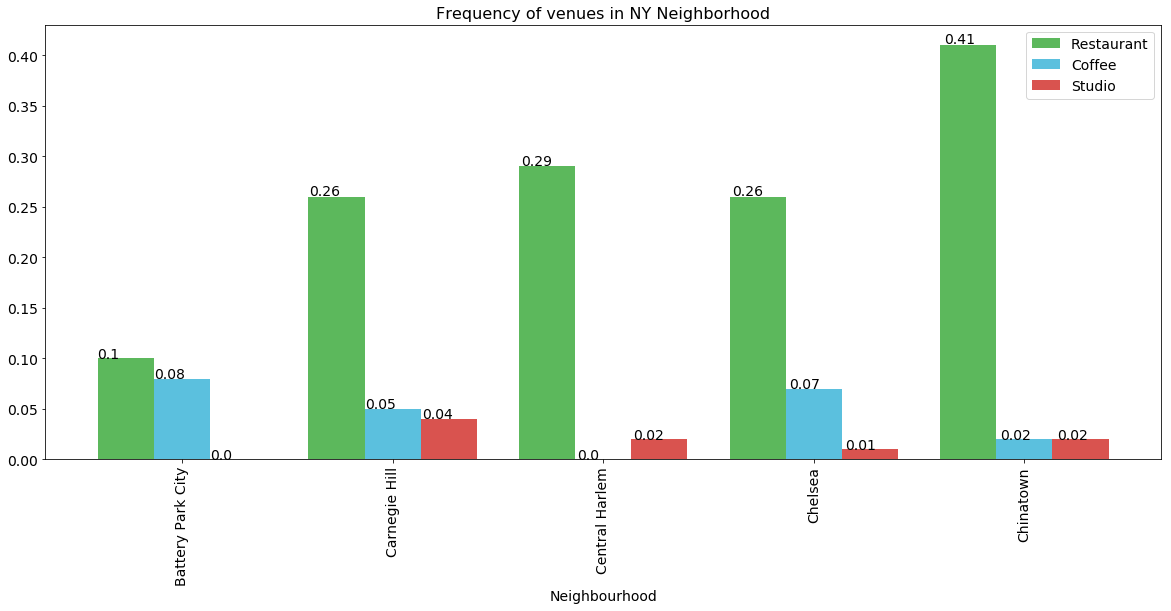

In [140]:
ax = df_final1.plot(kind='bar', 
              figsize=(20, 8), 
              width=(0.8),
              color = ['#5cb85c','#5bc0de','#d9534f'],
              edgecolor = 'none')
plt.title('Frequency of venues in NY Neighborhood', fontsize = 16)
plt.rcParams.update({'font.size': 14})
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
for p in ax.patches:
   ax.annotate(str(p.get_height()),(p.get_x() * 1.005, p.get_height() * 1.005))



In [47]:
len(manhattan_grouped3.columns)

336

#### Let's print each neighborhood along with the top 5 most common venues

In [48]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                venue  freq
0         Coffee Shop  0.08
1                Park  0.07
2               Hotel  0.05
3  Italian Restaurant  0.03
4           Wine Shop  0.03


----Carnegie Hill----
            venue  freq
0     Pizza Place  0.06
1  Cosmetics Shop  0.05
2     Coffee Shop  0.05
3            Café  0.04
4     Yoga Studio  0.03


----Central Harlem----
                  venue  freq
0    African Restaurant  0.07
1        Cosmetics Shop  0.07
2     French Restaurant  0.04
3  Gym / Fitness Center  0.04
4   American Restaurant  0.04


----Chelsea----
                 venue  freq
0          Coffee Shop  0.07
1   Italian Restaurant  0.06
2       Ice Cream Shop  0.05
3            Nightclub  0.04
4  American Restaurant  0.04


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1        Bubble Tea Shop  0.06
2           Cocktail Bar  0.04
3  Vietnamese Restaurant  0.04
4     Dim Sum Restaurant  0.04


----Civic Center----
            

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Park,Hotel,Wine Shop,Italian Restaurant,Gym,Pizza Place,Cupcake Shop,Women's Store,BBQ Joint
1,Carnegie Hill,Pizza Place,Cosmetics Shop,Coffee Shop,Café,Yoga Studio,Japanese Restaurant,French Restaurant,Bookstore,Bar,Gym
2,Central Harlem,Cosmetics Shop,African Restaurant,French Restaurant,Chinese Restaurant,Seafood Restaurant,Gym / Fitness Center,American Restaurant,Cycle Studio,Cafeteria,Market
3,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Bakery,Seafood Restaurant,Theater,Hotel,Cupcake Shop
4,Chinatown,Chinese Restaurant,Bubble Tea Shop,American Restaurant,Cocktail Bar,Vietnamese Restaurant,Dim Sum Restaurant,Hotpot Restaurant,Salon / Barbershop,Noodle House,Bakery


<a id='item4'></a>

Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [51]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 0, 0, 0, 0, 0, 4, 1, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [52]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Discount Store,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Shoe Store,Seafood Restaurant,Sandwich Place
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bubble Tea Shop,American Restaurant,Cocktail Bar,Vietnamese Restaurant,Dim Sum Restaurant,Hotpot Restaurant,Salon / Barbershop,Noodle House,Bakery
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Pizza Place,Tapas Restaurant,Sandwich Place,Chinese Restaurant,Shoe Store,Mexican Restaurant,Grocery Store
3,Manhattan,Inwood,40.867684,-73.921210,4,Lounge,Mexican Restaurant,Café,Pizza Place,Park,Bakery,Frozen Yogurt Shop,Restaurant,Deli / Bodega,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Mexican Restaurant,Deli / Bodega,Coffee Shop,Café,Pizza Place,Liquor Store,Cocktail Bar,Sandwich Place,School,Chinese Restaurant


Finally, let's visualize the resulting clusters

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

Examine Clusters

#### Cluster 1

In [54]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bubble Tea Shop,American Restaurant,Cocktail Bar,Vietnamese Restaurant,Dim Sum Restaurant,Hotpot Restaurant,Salon / Barbershop,Noodle House,Bakery
6,Central Harlem,Cosmetics Shop,African Restaurant,French Restaurant,Chinese Restaurant,Seafood Restaurant,Gym / Fitness Center,American Restaurant,Cycle Studio,Cafeteria,Market
8,Upper East Side,Italian Restaurant,Exhibit,Art Gallery,Coffee Shop,Bakery,Juice Bar,Hotel,French Restaurant,Boutique,Gym / Fitness Center
13,Lincoln Square,Theater,Gym / Fitness Center,Italian Restaurant,Plaza,Concert Hall,French Restaurant,Café,Performing Arts Venue,Park,Indie Movie Theater
14,Clinton,Theater,Coffee Shop,American Restaurant,Italian Restaurant,Gym / Fitness Center,Wine Shop,Spa,Hotel,Gym,Indie Theater
15,Midtown,Clothing Store,Hotel,Steakhouse,Coffee Shop,Theater,Bakery,Spa,Cocktail Bar,Bookstore,Park
17,Chelsea,Coffee Shop,Italian Restaurant,Ice Cream Shop,Nightclub,American Restaurant,Bakery,Seafood Restaurant,Theater,Hotel,Cupcake Shop
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Clothing Store,French Restaurant,Café,Indian Restaurant,Boutique,Chinese Restaurant,Seafood Restaurant,Yoga Studio
21,Tribeca,Italian Restaurant,Park,American Restaurant,Spa,Café,Boutique,Coffee Shop,Wine Bar,Gym,Greek Restaurant
22,Little Italy,Bakery,Café,Salon / Barbershop,Italian Restaurant,Ice Cream Shop,Sandwich Place,Bubble Tea Shop,Chinese Restaurant,Seafood Restaurant,Clothing Store


#### Cluster 2

In [55]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Pizza Place,Mexican Restaurant,Sushi Restaurant,Deli / Bodega,Japanese Restaurant,Dessert Shop
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Coffee Shop,Pizza Place,Gym / Fitness Center,Burger Joint,Sporting Goods Shop,Gym,Steakhouse,Bakery
12,Upper West Side,Italian Restaurant,Bar,Vegetarian / Vegan Restaurant,Burger Joint,Indian Restaurant,Bakery,Coffee Shop,Wine Bar,Sushi Restaurant,Mediterranean Restaurant
16,Murray Hill,Coffee Shop,Hotel,Sandwich Place,Bar,Gym,French Restaurant,Japanese Restaurant,Spa,Salon / Barbershop,Italian Restaurant
19,East Village,Ice Cream Shop,Bar,Wine Bar,Cocktail Bar,Mexican Restaurant,Chinese Restaurant,Pizza Place,Coffee Shop,Ramen Restaurant,Vegetarian / Vegan Restaurant
25,Manhattan Valley,Pizza Place,Coffee Shop,Yoga Studio,Deli / Bodega,Bar,Szechuan Restaurant,Mexican Restaurant,Spa,Thai Restaurant,Playground
27,Gramercy,Italian Restaurant,Coffee Shop,Wine Shop,Bagel Shop,American Restaurant,Cocktail Bar,Mexican Restaurant,Thrift / Vintage Store,Restaurant,Pizza Place
30,Carnegie Hill,Pizza Place,Cosmetics Shop,Coffee Shop,Café,Yoga Studio,Japanese Restaurant,French Restaurant,Bookstore,Bar,Gym
31,Noho,Italian Restaurant,French Restaurant,Cocktail Bar,Sushi Restaurant,Gift Shop,Grocery Store,Bookstore,American Restaurant,Mexican Restaurant,Hotel
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Juice Bar,Indian Restaurant,Furniture / Home Store,Bakery,American Restaurant,Dessert Shop,Bar,Pizza Place


#### Cluster 3

In [56]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Bar,Park,Playground,Gas Station,Pet Service,Boat or Ferry,German Restaurant,Farmers Market,Basketball Court,Baseball Field


#### Cluster 4

In [57]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,Park,Sandwich Place,Rental Car Location,Dog Run,Bus Line,Bus Station,Supermarket,Farmers Market,Outdoors & Recreation,Greek Restaurant
26,Morningside Heights,Coffee Shop,Bookstore,American Restaurant,Food Truck,Park,Deli / Bodega,Tennis Court,Burger Joint,Sandwich Place,Farmers Market
28,Battery Park City,Coffee Shop,Park,Hotel,Wine Shop,Italian Restaurant,Gym,Pizza Place,Cupcake Shop,Women's Store,BBQ Joint
29,Financial District,Coffee Shop,Hotel,Wine Shop,Bar,Gym,Steakhouse,Italian Restaurant,Café,Pizza Place,Food Truck


#### Cluster 5

In [58]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Discount Store,Coffee Shop,Yoga Studio,Deli / Bodega,Supplement Shop,Steakhouse,Shopping Mall,Shoe Store,Seafood Restaurant,Sandwich Place
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Pizza Place,Tapas Restaurant,Sandwich Place,Chinese Restaurant,Shoe Store,Mexican Restaurant,Grocery Store
3,Inwood,Lounge,Mexican Restaurant,Café,Pizza Place,Park,Bakery,Frozen Yogurt Shop,Restaurant,Deli / Bodega,Chinese Restaurant
4,Hamilton Heights,Mexican Restaurant,Deli / Bodega,Coffee Shop,Café,Pizza Place,Liquor Store,Cocktail Bar,Sandwich Place,School,Chinese Restaurant
5,Manhattanville,Seafood Restaurant,Chinese Restaurant,Deli / Bodega,Mexican Restaurant,Italian Restaurant,Grocery Store,Bike Trail,Sushi Restaurant,Supermarket,Burger Joint
7,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Latin American Restaurant,Pizza Place,Thai Restaurant,Chinese Restaurant,Taco Place,Street Art,Steakhouse
20,Lower East Side,Café,Coffee Shop,Ramen Restaurant,Pizza Place,Bakery,Park,Art Gallery,Cocktail Bar,Sandwich Place,Chinese Restaurant
36,Tudor City,Mexican Restaurant,Park,Café,Pizza Place,Greek Restaurant,Dog Run,Deli / Bodega,Hotel,Diner,Burger Joint


## Repeat the process for Toronto Neighbourhood

For Toronto data is not readily available. We are going to get the postal code data form wiki page using BeautifulSoup

In [59]:
from bs4 import BeautifulSoup

In [60]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np

Reading the table data from the wikipedia page

In [61]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

Reading the headers of the table

In [62]:
tr_elements = doc.xpath('//tr')
col=[]
i=0
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:"%s"'%(i,name))
    col.append((name,[]))

1:"Postcode"
2:"Borough"
3:"Neighbourhood
"


Reading the column values ignoring the first row(header row)

In [63]:
for j in range(1,len(tr_elements)):

    T=tr_elements[j]

    if len(T)!=3:
        break

    i=0
        
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
            try:
                data=int(data)
            except:
                pass
        col[i][1].append(data)
        
        i+=1

Know the number of rows in each column to verify all in sync

In [64]:
[len(C) for (title,C) in col]

[289, 289, 289]

In [65]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [66]:
df.head(5)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


In [67]:
df.count()

Postcode           289
Borough            289
Neighbourhood\n    289
dtype: int64

Ignore record with a borough that is Not assigned

In [68]:
df1=df[df.Borough != 'Not assigned']

In [69]:
df1.count()

Postcode           212
Borough            212
Neighbourhood\n    212
dtype: int64

In [ ]:
df1['Neighbourhood\n'] = df['Neighbourhood\n'].str.replace('\n', '')

In [71]:
df1.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


Merge rows which has same postal code Area

In [72]:
df2=df1.groupby(['Postcode','Borough'])['Neighbourhood\n'].apply(', '.join).reset_index()

In [73]:
df2.count()

Postcode           103
Borough            103
Neighbourhood\n    103
dtype: int64

In [74]:
df2.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [75]:
df2.dtypes

Postcode           object
Borough            object
Neighbourhood\n    object
dtype: object

Replace Neighbourhood values(Not assigned rows only) with Borough values.

In [76]:
df2.loc[df2['Neighbourhood\n'] == 'Not assigned', 'Neighbourhood\n'] = df2['Borough']
df2

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [77]:
df2.shape

(103, 3)

Read geographical coordinates from csv file

In [78]:
df3=pd.read_csv('http://cocl.us/Geospatial_data')

In [79]:
df3.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [80]:
df3.rename(columns={'Postal Code':'Postcode'}, inplace=True)

In [81]:
print(df3.columns)

Index(['Postcode', 'Latitude', 'Longitude'], dtype='object')


In [82]:
df4 = pd.merge(df2, df3, how='outer', on=['Postcode'])

In [83]:
df4

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [84]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [85]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [86]:
#### create map of Toronto
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df4['Latitude'], df4['Longitude'], df4['Borough'], df4['Neighbourhood\n']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [87]:
Toronto = df4[df4['Borough'].str.contains('Toronto')].reset_index(drop=True)
#Toronto = df4
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [88]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [89]:

toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Neighbourhood\n']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

In [90]:
CLIENT_ID = 'HB4HSFTYMS1GB54USKYJT0JSQ10A4GMIWLCSES0D5KR0BQ5J'
CLIENT_SECRET = 'TLHE00WA0TOPNSNEOG2JYGW3RV5ZO2YOVLVCZTSXQ0NCGCHF'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: HB4HSFTYMS1GB54USKYJT0JSQ10A4GMIWLCSES0D5KR0BQ5J
CLIENT_SECRET:TLHE00WA0TOPNSNEOG2JYGW3RV5ZO2YOVLVCZTSXQ0NCGCHF


In [91]:
Toronto.loc[0, 'Neighbourhood\n']

'The Beaches'

In [92]:
neighborhood_latitude = Toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Toronto.loc[0, 'Neighbourhood\n'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


In [93]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=HB4HSFTYMS1GB54USKYJT0JSQ10A4GMIWLCSES0D5KR0BQ5J&client_secret=TLHE00WA0TOPNSNEOG2JYGW3RV5ZO2YOVLVCZTSXQ0NCGCHF&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [94]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c7a2b039fb6b740ee6990ee'},
 'response': {'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a52011f820e3',
       'name': 'The Big Carrot Natural Food Market',
       'location': {'address': '125 Southwood Dr',
        'lat': 43.678879,
        'lng': -79.297734,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.678879,
          'lng': -79.297734}],
        'distance': 471,
        'postalCode': 'M4E 0B8',
   

In [95]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [96]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
1,Grover Pub and Grub,Pub,43.679181,-79.297215
2,Starbucks,Coffee Shop,43.678798,-79.298045
3,Glen Stewart Park,Park,43.675278,-79.294647
4,Upper Beaches,Neighborhood,43.680563,-79.292869


In [97]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

6 venues were returned by Foursquare.


In [98]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [99]:
toronto_venues = getNearbyVenues(names=Toronto['Neighbourhood\n'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude']
                                  )



The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [100]:
print(toronto_venues.shape)
toronto_venues.head()

(1707, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
3,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [101]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",19,19,19,19,19,19
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",48,48,48,48,48,48
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16


In [102]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 242 uniques categories.


In [103]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0

In [104]:
toronto_onehot.shape

(1707, 242)

In [105]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.030000,0.0000,0.000000,0.000000,0.0000,0.000000,0.030000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.01,0.020000,0.000000,0.000000,0.01,0.020000,0.010000,0.00,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.060000,0.000000,0.000

In [106]:
toronto_grouped.shape

(38, 242)

In [107]:
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,0.0,0.010000,0.01,0.0,0.03,0.0,0.000000,0.000000,0.0,0.000000,0.030000,0.0,0.030000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.02,0.000000,0.01,0.020000,0.000000,0.0,0.01,0.02,0.010000,0.0,0.000000,0.050000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.030000,0.010000,0.060000,0.0,0.0,0.0,0.000000,0.000000,0.020000,0.000000,0.020000,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,

In [108]:
toronot_grouped1 = toronto_grouped.round(2)

In [109]:
toronto_grouped2 = toronot_grouped1.replace(0.00, np.nan)
toronto_grouped2.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,0.01,0.01,NaN,0.03,NaN,NaN,NaN,NaN,NaN,0.03,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,0.01,0.02,NaN,NaN,0.01,0.02,0.01,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.01,0.06,NaN,NaN,NaN,NaN,NaN,0.02,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,0.01,NaN,NaN,0.01,NaN,0.01,NaN,0.03,0.0

In [110]:
toronto_grouped2.shape

(38, 242)

In [111]:
toronto_grouped3= toronto_grouped2.dropna(how='all')

In [112]:
toronto_grouped3.shape

(38, 242)

In [113]:
toronto_grouped.columns

Index(['Neighborhood', 'Yoga Studio', 'Adult Boutique', 'Afghan Restaurant',
       'Airport', 'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal',
       ...
       'Toy / Game Store', 'Trail', 'Train Station',
       'Vegetarian / Vegan Restaurant', 'Video Game Store',
       'Vietnamese Restaurant', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store'],
      dtype='object', length=242)

In [114]:
len(toronto_grouped.columns)

242

In [115]:
toronto_grouped1=toronto_grouped.round(2)
toronto_grouped2 = toronto_grouped1.replace(0.00, np.nan)
toronto_grouped2.head()
toronto_grouped3= toronto_grouped2.dropna(how='all')

In [116]:
toronto_grouped3.shape

(38, 242)

In [117]:
#col_list= list(manhattan_grouped3)
col_list_t = [col_t for col_t in toronto_grouped3.columns if 'Restaurant' in col_t]
col_list1_t = [col1_t for col1_t in toronto_grouped3.columns if 'Coffee' in col1_t]
col_list2_t = [col2_t for col2_t in toronto_grouped3.columns if 'Park' in col2_t]
col_list3_t = [col3_t for col3_t in toronto_grouped3.columns if 'Studio' in col3_t]


In [118]:
toronto_grouped3['Restaurant3'] = toronto_grouped3[col_list_t].sum(axis=1)
toronto_grouped3['Coffee3'] = toronto_grouped3[col_list1_t].sum(axis=1)
toronto_grouped3['Park3'] = toronto_grouped3[col_list2_t].sum(axis=1)
toronto_grouped3['Studio3'] = toronto_grouped3[col_list3_t].sum(axis=1)

In [119]:
toronto_grouped3.columns

Index(['Neighborhood', 'Yoga Studio', 'Adult Boutique', 'Afghan Restaurant',
       'Airport', 'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal',
       ...
       'Video Game Store', 'Vietnamese Restaurant', 'Wine Bar', 'Wine Shop',
       'Wings Joint', 'Women's Store', 'Restaurant3', 'Coffee3', 'Park3',
       'Studio3'],
      dtype='object', length=246)

In [120]:
toronto_grouped3.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Restaurant3,Coffee3,Park3,Studio3
0,"Adelaide, King, Richmond",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,NaN,0.01,0.01,NaN,0.03,NaN,NaN,NaN,NaN,NaN,0.03,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,0.01,0.02,NaN,NaN,0.01,0.02,0.01,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.01,0.06,NaN,NaN,NaN,NaN,NaN,0.02,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,0.01,

In [121]:
df_new_t = pd.DataFrame()
df_new_t['Neighbourhood'] = toronto_grouped3['Neighborhood']
df_new_t['Restaurant'] = toronto_grouped3['Restaurant3']
df_new_t['Coffee'] = toronto_grouped3['Coffee3']
df_new_t['Studio'] = toronto_grouped3['Studio3']

In [122]:
df_new_t.head(5)

,Neighbourhood,Restaurant,Coffee,Studio
0,"Adelaide, King, Richmond",0.27,0.06,0.00
1,Berczy Park,0.23,0.07,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.10,0.11,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.12,0.00,0.12
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.00,0.00,0.00


In [123]:
df_final_t= pd.DataFrame()
df_final_t = df_new_t.head(5)

In [124]:
df_final_t.shape
df_final1_t = df_final_t.round(2)
df_final1_t.set_index('Neighbourhood', inplace=True)
df_final1_t.head()

,Restaurant,Coffee,Studio
Neighbourhood,,,
"Adelaide, King, Richmond",0.27,0.06,0.00
Berczy Park,0.23,0.07,0.00
"Brockton, Exhibition Place, Parkdale Village",0.10,0.11,0.00
Business Reply Mail Processing Centre 969 Eastern,0.12,0.00,0.12
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.00,0.00,0.00


In [125]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

Creating bar chart for venues in the neighbourhood of Toronto

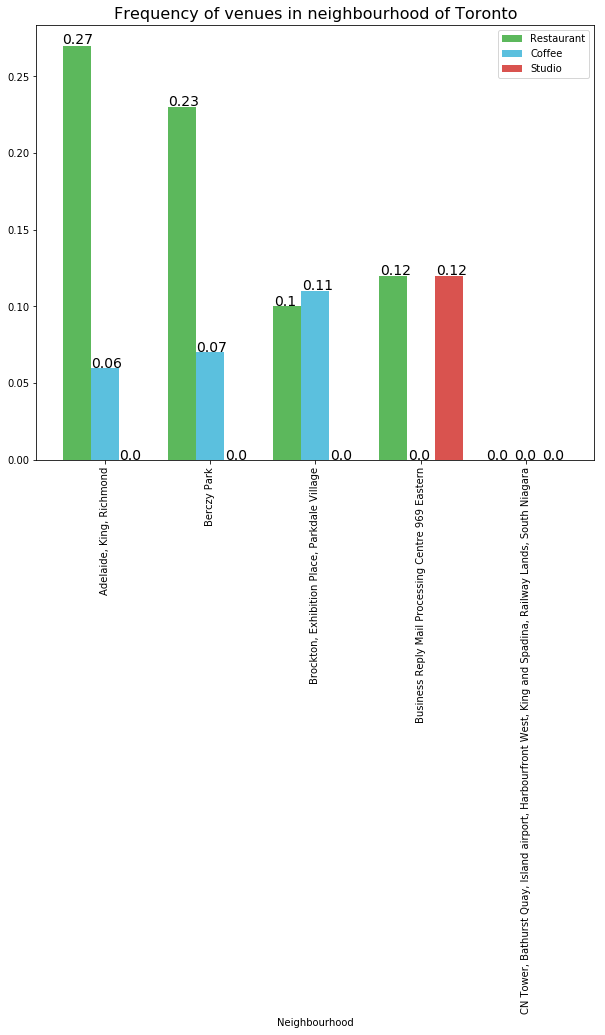

In [126]:
ax = df_final1_t.plot(kind='bar', 
              figsize=(10, 8), 
              width=(0.8),
              color = ['#5cb85c','#5bc0de','#d9534f'],
              edgecolor = 'none')
plt.title('Frequency of venues in neighbourhood of Toronto', fontsize = 16)
plt.rcParams.update({'font.size': 14})
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.axes.get_yaxis().set_visible(False)
for p in ax.patches:
   ax.annotate(str(p.get_height()),(p.get_x() * 1.005, p.get_height() * 1.005))



In [127]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
   # new_df['venue']=temp['venue']
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3      Thai Restaurant  0.04
4  American Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2          Restaurant  0.05
3  Italian Restaurant  0.04
4      Farmers Market  0.04


----Brockton, Exhibition Place, Parkdale Village----
                   venue  freq
0         Breakfast Spot  0.11
1                   Café  0.11
2            Coffee Shop  0.11
3           Climbing Gym  0.05
4  Performing Arts Venue  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Light Rail Station  0.11
1           Yoga Studio  0.06
2  Fast Food Restaurant  0.06
3         Auto Workshop  0.06
4         Garden Center  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
     

In [128]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [129]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,American Restaurant,Thai Restaurant,Steakhouse,Gym,Clothing Store,Asian Restaurant,Bakery,Bar
1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Seafood Restaurant,Bakery,Italian Restaurant,Steakhouse,Farmers Market,Café,Pub
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Pet Store,Climbing Gym,Performing Arts Venue,Stadium,Burrito Place,Bar,Caribbean Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Garden,Park,Pizza Place,Recording Studio,Restaurant,Butcher,Burrito Place,Brewery
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Plane,Boat or Ferry,Airport Gate,Airport Food Court,Airport


In [130]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [131]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood\n')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Health Food Store,Pub,Park,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Pizza Place,Sushi Restaurant,Board Shop,Brewery,Burger Joint,Burrito Place,Sandwich Place,Pub,Pet Store,Park
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Bus Line,Dim Sum Restaurant,Park,Swim School,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Women's Store


In [132]:
#toronto_merged['Cluster Labels']=pd.to_numeric(toronto_merged['Cluster Labels'])
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].fillna(0.0).astype(int)

In [133]:
toronto_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Health Food Store,Pub,Park,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Pizza Place,Sushi Restaurant,Board Shop,Brewery,Burger Joint,Burrito Place,Sandwich Place,Pub,Pet Store,Park
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Bus Line,Dim Sum Restaurant,Park,Swim School,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Women's Store


In [134]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood\n'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examining the clusters

In [135]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Coffee Shop,Health Food Store,Pub,Park,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant
2,East Toronto,0,Pizza Place,Sushi Restaurant,Board Shop,Brewery,Burger Joint,Burrito Place,Sandwich Place,Pub,Pet Store,Park
3,East Toronto,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
5,Central Toronto,0,Gym,Burger Joint,Park,Hotel,Breakfast Spot,Sandwich Place,Clothing Store,Food & Drink Shop,Women's Store,Dumpling Restaurant
6,Central Toronto,0,Clothing Store,Sporting Goods Shop,Coffee Shop,Yoga Studio,Rental Car Location,Spa,Fast Food Restaurant,Mexican Restaurant,Diner,Sandwich Place
7,Central Toronto,0,Pizza Place,Sandwich Place,Dessert Shop,Sushi Restaurant,Italian Restaurant,Café,Coffee Shop,Pharmacy,Seafood Restaurant,Greek Restaurant
8,Central Toronto,0,Playground,Tennis Court,Gym,Restaurant,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
9,Central Toronto,0,Pub,Coffee Shop,Light Rail Station,Sushi Restaurant,Supermarket,Bagel Shop,Sports Bar,American Restaurant,Fried Chicken Joint,Vietnamese Restaurant
11,Downtown Toronto,0,Coffee Shop,Restaurant,Pharmacy,Market,Bakery,Café,Pub,Pizza Place,Park,Italian Restaurant


In [136]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,1,Park,Playground,Trail,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [137]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,2,Garden,Women's Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [138]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,3,Bus Line,Trail,Sushi Restaurant,Jewelry Store,Women's Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [139]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,4,Bus Line,Dim Sum Restaurant,Park,Swim School,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Women's Store


## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>